In [1]:
!ls

File inspection.ipynb  PAXhs_vs_Pw-aa.blastp.txt  PAX.Xenopus.aa.fasta
pax7_start_hits.bed    PAXhs_vs_Pw.tblastn.txt	  SOX_vs_Pw.tblastn.txt
PAX.Hsapiens.aa.fasta  PAX_vs_Pw.tblastn.txt	  SOX.Xenopus.aa.fasta


In [2]:
%matplotlib inline

In [3]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import itertools
from matplotlib import collections as mc
import pylab
import numpy as np

## 1. Read Tblastn hits from the human PAX proteins to the salamander scaffolds

In [4]:
blast_cols = ["query_id","subject_id","pct_id","ali_len","mism","gap_open","q_start","q_end","s_start","s_end","e_value","bitscore"]
pax_hits = pd.read_csv("PAXhs_vs_Pw.tblastn.txt",sep="\t",header=None,names=blast_cols)
print( "Size of dataframe: {}".format(pax_hits.shape ))
pax_hits.head()

Size of dataframe: (404, 12)


,query_id,subject_id,pct_id,ali_len,mism,gap_open,q_start,q_end,s_start,s_end,e_value,bitscore
0,PAX1_Hsapiens,Pw_938150,87.85,214,21,4,96,306,1450,815,1.000000e-113,372.0
1,PAX1_Hsapiens,Pw_1163203,74.70,83,21,0,92,174,3367,3119,1.000000e-27,127.0
2,PAX1_Hsapiens,Pw_1163203,62.79,43,16,0,171,213,752,624,1.000000e-08,66.6
3,PAX1_Hsapiens,Pw_2510707,70.67,75,22,0,141,215,490,266,1.000000e-21,107.0
4,PAX1_Hsapiens,Pw_2510707,73.81,42,11,0,102,143,1354,1229,2.000000e-08,65.9


## 2. Calculate protein lenghts from human PAX proteins fasta

In [5]:
def get_seq_len_from_fasta(fasta_file):
    seqs = defaultdict(int)
    current_id = ""
    with open(fasta_file) as fh:
        for line in fh:
            if line.startswith(">"):
                current_id = line.lstrip(">").rstrip("\n")
            else:
                seqs[current_id] += len(line.rstrip("\n"))
    return seqs

pax_lengths = get_seq_len_from_fasta("PAX.Hsapiens.aa.fasta")

In [6]:
print(pax_lengths)

defaultdict(<class 'int'>, {'PAX3_Hsapiens': 479, 'PAX1_Hsapiens': 534, 'PAX2_Hsapiens': 417, 'PAX6_Hsapiens': 422, 'PAX4_Hsapiens': 350, 'PAX8_Hsapiens': 450, 'PAX9_Hsapiens': 341, 'PAX5_Hsapiens': 391, 'PAX7_Hsapiens': 505})


In [7]:
print(pax_hits.shape)
print(pax_hits[pax_hits.e_value < 1e-10].shape)

(404, 12)
(220, 12)


In [8]:
pax_hits.groupby("query_id")["subject_id"].size()

query_id
PAX1_Hsapiens    27
PAX2_Hsapiens    35
PAX3_Hsapiens    80
PAX4_Hsapiens    28
PAX5_Hsapiens    37
PAX6_Hsapiens    58
PAX7_Hsapiens    81
PAX8_Hsapiens    30
PAX9_Hsapiens    28
dtype: int64

In [9]:
lol = pax_hits.groupby("query_id")["subject_id"].unique()
lol.apply(lambda x:len(x))

query_id
PAX1_Hsapiens    21
PAX2_Hsapiens    28
PAX3_Hsapiens    72
PAX4_Hsapiens    26
PAX5_Hsapiens    28
PAX6_Hsapiens    48
PAX7_Hsapiens    72
PAX8_Hsapiens    22
PAX9_Hsapiens    22
Name: subject_id, dtype: int64

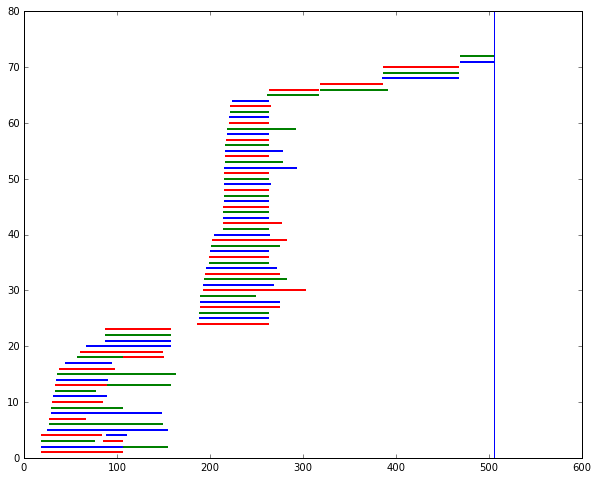

In [10]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

gene_name = "PAX7_Hsapiens"
df = pax_hits[pax_hits.query_id == gene_name]
#Order contigs by query start
contig_idx = dict( (ctg_id, idx+1 ) for idx,ctg_id in enumerate(
            df[["subject_id","q_start"]].sort_values(by="q_start").drop_duplicates("subject_id",keep="first").subject_id 
                  ))
lines = [ [(q_st,contig_idx[s_id]),(q_end,contig_idx[s_id])] for s_id,q_st,q_end in 
df[["subject_id","q_start","q_end"]].sort_values(by="q_start").apply(lambda row: tuple(row),axis=1)
]
lc1 = mc.LineCollection(lines[0::3],linewidths=2,color="red")
lc2 = mc.LineCollection(lines[1::3],linewidths=2,color="blue")
lc3 = mc.LineCollection(lines[2::3],linewidths=2,color="green")
fig,ax = plt.subplots()
ax.add_collection(lc1)
ax.add_collection(lc2)
ax.add_collection(lc3)
ax.axvline(pax_lengths[gene_name])
ax.autoscale()

## Hit extraction

In [26]:
!mkdir out/
#Filter by gene
df = pax_hits[pax_hits.query_id == "PAX7_Hsapiens"]
#Filter by gene region
df = df[(df.q_start > 180) & (df.q_start < 250)]
#Write to file
df[["subject_id","s_start","s_end"]].to_csv("out/pax7_middle_hits.bed",sep="\t",index=None,header=False)
#Print table
df.sort_values(by="q_start").head()

,query_id,subject_id,pct_id,ali_len,mism,gap_open,q_start,q_end,s_start,s_end,e_value,bitscore
270,PAX7_Hsapiens,Pw_1123873,78.21,78,17,0,186,263,4842,5075,7.000000e-28,127.0
303,PAX7_Hsapiens,Pw_422920,53.75,80,29,3,188,263,1083,1310,4.000000e-12,77.8
304,PAX7_Hsapiens,Pw_124418,53.75,80,29,3,188,263,29868,30095,4.000000e-12,77.8
333,PAX7_Hsapiens,Pw_391938,35.63,87,56,0,189,275,4056,3796,7.000000e-07,60.8
321,PAX7_Hsapiens,Pw_2083840,59.02,61,22,1,189,249,3388,3561,1.000000e-08,66.6
334,PAX7_Hsapiens,Pw_68547,35.63,87,56,0,189,275,4871,5131,8.000000e-07,60.8
298,PAX7_Hsapiens,Pw_1176810,44.44,117,57,2,192,303,725,1066,4.000000e-14,82.8
342,PAX7_Hsapiens,Pw_6015308,41.03,78,43,2,192,269,453,677,6.000000e-06,56.6
338,PAX7_Hsapiens,Pw_2848915,32.61,92,60,1,194,283,217,492,4.000000e-06,58.2
316,PAX7_Hsapiens,Pw_784005,44.44,81,38,1,195,275,1266,1045,4.000000e-09,68.2


## Greedy strategy to extract longest contigs for each gene

In [12]:
def calculate_cov(contig_set,gene_length):
    bitmap = np.zeros(gene_length)
    for hit in contig_set:
        bitmap[hit[1]-1:hit[2]] = 1
    return bitmap.sum()

In [14]:
gene_name = "PAX6_Hsapiens"
df = pax_hits[pax_hits.query_id == gene_name]

#Extract lists of hits for protein
hits_list = df[["subject_id","q_start","q_end"]].apply(lambda row:tuple(row),axis=1).tolist()

#Greedy Algorithm starts here
contig_set = tuple()
last_it_cvg= 0
it_cvg_delta = 11
min_cov_increase = 10

while hits_list and (it_cvg_delta > min_cov_increase):
    it_best_hit = tuple()
    it_best_cvg = 0
    #Try which combination of current contig_set + a hit gives the largest coverage increase
    for hit in hits_list:
        cvg = calculate_cov( contig_set + (hit,) , pax_lengths[gene_name])
        if cvg > it_best_cvg:
            it_best_hit = hit
            it_best_cvg = cvg
        
    print("Max_it_cvg : {}".format(it_best_cvg))
    #Calculate coverage increase
    it_cvg_delta = it_best_cvg - last_it_cvg
    #IF delta if better than the minimun, add the hit
    if  it_cvg_delta > min_cov_increase:
        last_it_cvg = it_best_cvg
        contig_set = contig_set + (it_best_hit,)
        hits_list.remove(hit)

print(contig_set)

Max_it_cvg : 138.0
Max_it_cvg : 206.0
Max_it_cvg : 255.0
Max_it_cvg : 299.0
Max_it_cvg : 336.0
Max_it_cvg : 370.0
Max_it_cvg : 373.0
(('Pw_938150', 2, 139), ('Pw_2885311', 189, 256), ('Pw_577196', 256, 305), ('Pw_3748617', 343, 386), ('Pw_577196', 306, 344), ('Pw_3948717', 120, 173))
